# Keyword extraction

In [2]:
# Import essential libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import yake
import nltk
# nltk.download('omw-1.4')

def yake_extractor(data_list, lemmatizer, stopwords, language = "en", max_ngram_size = 3, deduplication_thresold = 0.9, 
    deduplication_algo = 'seqm', windowSize = 1, numOfKeywords =100):
    # preprocess data
    lower_data = [data.lower() for data in data_list]
    lem_data = [lemmatizer.lemmatize(data) for data in lower_data]
    # text = []
    # for data in lem_data:
    #     text.append(' '.join([w for w in data.split() if w not in stopwords]))
    text = ' '.join(lem_data)
    # extract keywords
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size,  dedupLim=deduplication_thresold,
                            dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None, stopwords=stopwords)
    keywords = custom_kw_extractor.extract_keywords(text)
    return keywords

if __name__ == '__main__':
    stopwords = set(STOPWORDS)
    lemmatizer = WordNetLemmatizer()

    data_path = r"C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\PROJECTS\Misinformation\Misinformation_literature_review\metadata\merged_all_data\journal+doi+abstract+year+citation+fieldofstudy_dropnull.csv"
    out_path = r'C:\Users\huyen\Documents\GitHub\Misinformation\Data analysis\Content analysis\keyword.csv'
    
    with open(data_path, 'r', encoding = 'utf-8') as f:    
        data = pd.read_csv(f)
    print(data.columns)

    join_fn = lambda x : ' '.join([x.title, x.abstract])
    join_text = data.apply(join_fn, axis=1)
    keywords = yake_extractor(data_list = join_text.tolist(), lemmatizer = lemmatizer, stopwords = stopwords)
    
    # write output to file
    f = open(out_path, 'w')
    f.writelines('keyword,score\n')
    for (w, s) in keywords: 
        f = open(out_path, 'a+')
        f.write('%s,%f\n' %(w,s))   
    f.close()


Index(['Unnamed: 0', 'title', 'authors', 'venue', 'year', 'citationCount',
       'fieldsOfStudy', 'abstract', 'doi', 'query', 'database',
       'publication_type'],
      dtype='object')


KeyboardInterrupt: 

# Topic modeling

In [ ]:
# Import essential libraries
import pandas as pd
from nltk.tokenize import RegexpTokenizer
# from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS

from nltk.stem.porter import PorterStemmer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

def preprocessing (tokenizer, text):
    """
    text: str
    """
    stopwords = set(STOPWORDS)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
     # Remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopwords]
    # Stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens if len(i)>3]
    return stemmed_tokens

def get_lda_topic (texts, n_topics =[20, 25, 30, 35, 40], n_words = 12):
    """
    texts: a list of token lists
    """
    # Turn our tokenized documents into a id - term dictionary
    dictionary = corpora.Dictionary(texts)
    # Convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Find the best n_topics
    models = {}
    topics = {} 
    coherence = {}
    for i in n_topics:
        # Generate LDA model
        print('--------- %s ---------'%str(i))
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary, passes=60, alpha='auto',
                            random_state=42)
        shown_topics = ldamodel.show_topics(num_topics=i, 
                                             num_words=n_words,
                                             formatted=False)
        topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
        # Compute Coherence Score
        coherence_ldamodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_ldamodel.get_coherence()
        coherence[i] = coherence_lda
        print('Coherence Score: ', coherence_lda)

    return topics, coherence

if __name__ == '__main__':
    # Create Tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # Create PorterStemmer
    p_stemmer = PorterStemmer()

    # Save topics to CSV
    data_path = r"C:\Users\hn0139\OneDrive - UNT System\A_PhD_PATH\PROJECTS\Misinformation\Misinformation_literature_review\metadata\merged_all_data\journal+doi+abstract+year+citation+fieldofstudy_dropnull.csv"
    out_path = r'C:\Users\hn0139\Documents\GitHub\Misinformation\Data analysis\Content analysis\topics.csv'
    
    with open(data_path, 'r', encoding = 'utf-8') as f:    
        data = pd.read_csv(f)

    join_fn = lambda x : ' '.join([x.title, x.abstract])
    join_text = data.apply(join_fn, axis=1)

    clean_text = [preprocessing(tokenizer, text) for text in join_text]
    
    topics, coherences = get_lda_topic (clean_text, n_topics = [30], n_words = 10) # 25, 30, 35, 40
    best_cor_score = max(list(coherences.values()))
    best_cor_idx = list(coherences.values()).index(best_cor_score)
    best_n_topics = {v:k for k, v in coherences.items()}[best_cor_score]

    best_topics = pd.DataFrame(topics[best_n_topics])
    print('best n_topic: {} topics. Cohenrence score: {} \nTopics: \n{}'.format(best_n_topics, coherences, best_topics))
    with open (out_path, 'w',  newline="", encoding='utf-8') as file:
        best_topics.to_csv(file)


--------- 30 ---------
Coherence Score:  0.4849451488002597
best n_topic: 30 topics. Cohenrence score: {30: 0.4849451488002597} 
Topics: 
             0         1            2          3         4          5  \
0         spam      mail       attack     messag     email     system   
1       social     media       inform  misinform   twitter    content   
2        model   network       spread      rumor    inform     propag   
3       rumour    market         food     consum   product      stock   
4        coupl       lie      pathway     poison     toler     pseudo   
5      patient     medic    treatment    publish    clinic       case   
6        cyber     youth   cyberbulli    aggress      self      trait   
7       inform   student        studi   research      educ   literaci   
8       inform    commun        manag       risk      care     health   
9        troll     studi        onlin        use     bulli   behavior   
10      review      user     research        use      base 


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\huyen\AppData\Local\Temp\ipykernel_18888\1280187568.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = 'n_topics', y = 'coherence', data = df_cor, palette='salmon', marker = 'o') #, saturation=0.70


     -------------------------------------- 285.1/285.1 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


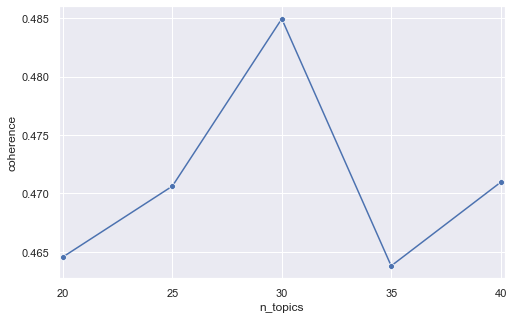

In [4]:
# %pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Viz the coherence score
cor_dic = {'20': 0.4645722276139618,
'25': 0.470628677985547,
'30': 0.4849451488002597,
'35': 0.46380498878700577,
'40': 0.47095674013627525}

df_cor = pd.DataFrame(cor_dic.items(), columns = ['n_topics', 'coherence'])

plt.figure(figsize=(8,5))
sns.set_theme(style="darkgrid") 
sns.lineplot(x = 'n_topics', y = 'coherence', data = df_cor, palette='salmon', marker = 'o') #, saturation=0.70
# plt.xticks(ha = 'right')
# plt.tick_params(axis='both', which='minor', labelsize=6)
plt.margins(x=0.01)
plt.show()

In [9]:
# Import essential libraries
import pandas as pd
from nltk.tokenize import RegexpTokenizer
# from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS

from nltk.stem.porter import PorterStemmer
# %pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


def preprocessing(tokenizer, text):
    """
    text: str
    """
    stopwords = set(STOPWORDS)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    # Remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopwords]
    # Stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens if len(i)>3]
    return stemmed_tokens


def get_lda_topic(texts, n_topics =[20, 25, 30, 35, 40], n_words = 12):
    """
    texts: a list of token lists
    """
    # Turn our tokenized documents into a id - term dictionary
    dictionary = corpora.Dictionary(texts)
    # Convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Find the best n_topics
    models = {}
    topics = {} 
    coherence = {}
    for i in n_topics:
        # Generate LDA model
        print('--------- %s ---------'%str(i))
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary, passes=60, alpha='auto', random_state=42)
        shown_topics = ldamodel.show_topics(num_topics=i, 
                                            num_words=n_words,
                                            formatted=False)
        topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
        # Compute Coherence Score
        coherence_ldamodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_ldamodel.get_coherence()
        coherence[i] = coherence_lda
        print('Coherence Score: ', coherence_lda)

    return topics, coherence


if __name__ == '__main__':
    # Create Tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # Create PorterStemmer
    p_stemmer = PorterStemmer()

    # data_path = r"C:\Users\hn0139\OneDrive - UNT System\A_PhD_PATH\PROJECTS\Misinformation\Misinformation_literature_review\metadata\merged_all_data\journal+doi+abstract+year+citation+fieldofstudy_dropnull.csv"
    # out_path = r'C:\Users\hn0139\Documents\GitHub\Misinformation\Data analysis\Content analysis\topics.csv'
    data_path = r"C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\PROJECTS\Misinformation\Misinformation_literature_review\analysis\backup_coded-data-analysis_08282022\backup_coded-data-analysis_08282022.csv"
    out_path = r'C:\Users\huyen\OneDrive\Documents\GitHub\Misinformation\Data analysis\Content analysis\topics_subset_results.csv'

    with open(data_path, 'r', encoding = 'utf-8') as f:    
        data = pd.read_csv(f)
    print(data.columns)
    print(data.shape)
    # print(data['Results'])

    # join_fn = lambda x : ' '.join([x.title, x.abstract])
    # join_text = data.apply(join_fn, axis=1)

    clean_text = [preprocessing(tokenizer, text) for text in data['Results'] if isinstance(text, str)]
    
    topics, coherences = get_lda_topic (clean_text, n_topics = [10,11,12,13,14,15], n_words = 10) # 25, 30, 35, 40
    best_cor_score = max(list(coherences.values()))
    best_cor_idx = list(coherences.values()).index(best_cor_score)
    best_n_topics = {v:k for k, v in coherences.items()}[best_cor_score]

    best_topics = pd.DataFrame(topics[best_n_topics])
    print('best n_topic: {} topics. Cohenrence score: {} \nTopics: \n{}'.format(best_n_topics, coherences, best_topics))
    with open(out_path, 'w',  newline="", encoding='utf-8') as file:
        best_topics.to_csv(file)


Index(['Excluding?', 'Title', 'URL', 'Dataset', 'Framework/theory',
       'Research questions', 'Research purpose', 'Results', 'Future direction',
       'Remarks', 'Publication year', 'Citation', 'Publisher'],
      dtype='object')
(161, 13)
--------- 10 ---------
Coherence Score:  0.3632769292819366
--------- 11 ---------
Coherence Score:  0.36143669159836095
--------- 12 ---------
Coherence Score:  0.3635279680112909
--------- 13 ---------
Coherence Score:  0.3618298293860565
--------- 14 ---------
Coherence Score:  0.37275803427920545
--------- 15 ---------
Coherence Score:  0.37643825039487994
best n_topic: 15 topics. Cohenrence score: {10: 0.3632769292819366, 11: 0.36143669159836095, 12: 0.3635279680112909, 13: 0.3618298293860565, 14: 0.37275803427920545, 15: 0.37643825039487994} 
Topics: 
            0         1         2           3              4            5  \
0       studi    promot     found       trust           case        sourc   
1        fake     among    intent     